# Gradient Visualization for 3D Stellar Wind Simulation

## Imports

In [11]:
# numerics
import jax
import jax.numpy as jnp
# # for now using CPU as of outdated NVIDIA Driver
# jax.config.update('jax_platform_name', 'cpu')
# # jax.config.update('jax_disable_jit', True)
# # 64-bit precision
jax.config.update("jax_enable_x64", True)

# debug nans
# jax.config.update("jax_debug_nans", True)

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# fluids
from jf1uids import WindParams
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids.fluid_equations.fluid import construct_primitive_state

from jf1uids import get_registered_variables
from jf1uids.option_classes import WindConfig

from jf1uids.option_classes.simulation_config import BACKWARDS, OSHER

# units
from jf1uids import CodeUnits
from astropy import units as u
import astropy.constants as c
from astropy.constants import m_p

# wind-specific
from jf1uids._physics_modules._stellar_wind.weaver import Weaver

# turbulence
from jf1uids.initial_condition_generation.turb import create_turb_field

## Initiating the stellar wind simulation

In [12]:
from jf1uids.option_classes.simulation_config import FORWARDS


print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
box_size = 1.0
num_cells = 128

# activate stellar wind
stellar_wind = True

# turbulence
turbulence = False
wanted_rms = 50 * u.km / u.s

fixed_timestep = False
scale_time = False
dt_max = 0.1
num_timesteps = 2000

# setup simulation config
config = SimulationConfig(
    runtime_debugging = False,
    first_order_fallback = False,
    progress_bar = True,
    dimensionality = 3,
    num_ghost_cells = 2,
    box_size = box_size, 
    num_cells = num_cells,
    wind_config = WindConfig(
        stellar_wind = stellar_wind,
        num_injection_cells = 12,
        trace_wind_density = False,
    ),
    fixed_timestep = fixed_timestep,
    differentiation_mode = FORWARDS,
    num_timesteps = num_timesteps,
)

helper_data = get_helper_data(config)

registered_variables = get_registered_variables(config)

👷 Setting up simulation...


## Setting the simulation parameters and initial state

In [13]:

from jf1uids.initial_condition_generation.turb import create_incompressible_turb_field
from jf1uids.option_classes.simulation_config import finalize_config

code_length = 3 * u.parsec
code_mass = 1 * u.M_sun
code_velocity = 100 * u.km / u.s
code_units = CodeUnits(code_length, code_mass, code_velocity)

# time domain
C_CFL = 0.4
# 2.5

t_final = 1.0 * 1e4 * u.yr
t_end = t_final.to(code_units.code_time).value

if scale_time:
    t_end = dt_max * num_timesteps
print(t_end)


# wind parameters
M_star = 40 * u.M_sun
wind_final_velocity = 2000 * u.km / u.s
wind_mass_loss_rate = 2.965e-3 / (1e6 * u.yr) * M_star

wind_params = WindParams(
    wind_mass_loss_rate = wind_mass_loss_rate.to(code_units.code_mass / code_units.code_time).value,
    wind_final_velocity = wind_final_velocity.to(code_units.code_velocity).value
)

params = SimulationParams(
    C_cfl = C_CFL,
    dt_max = dt_max,
    gamma = gamma,
    t_end = t_end,
    wind_params = wind_params
)

# homogeneous initial state
rho_0 = 2 * c.m_p / u.cm**3
p_0 = 3e4 * u.K / u.cm**3 * c.k_B

print(p_0.to(code_units.code_pressure).value)

rho = jnp.ones((config.num_cells, config.num_cells, config.num_cells)) * rho_0.to(code_units.code_density).value

u_x = jnp.zeros((config.num_cells, config.num_cells, config.num_cells))
u_y = jnp.zeros((config.num_cells, config.num_cells, config.num_cells))
u_z = jnp.zeros((config.num_cells, config.num_cells, config.num_cells))

x = jnp.linspace(0, config.box_size, config.num_cells)
y = jnp.linspace(0, config.box_size, config.num_cells)
z = jnp.linspace(0, config.box_size, config.num_cells)

turbulence_slope = -2
kmin = 2
kmax = 64

if turbulence:
    ux = create_turb_field(config.num_cells, 1, turbulence_slope, kmin, kmax, seed = 1)
    uy = create_turb_field(config.num_cells, 1, turbulence_slope, kmin, kmax, seed = 2)
    uz = create_turb_field(config.num_cells, 1, turbulence_slope, kmin, kmax, seed = 3)

    # ux, uy, uz = create_incompressible_turb_field(config.num_cells, 1, turbulence_slope, kmin, kmax, seed = 1)

    a = num_cells // 2 - 10
    b = num_cells // 2 + 10

    u_x = ux# .at[a:b, a:b, a:b].set(ux[a:b, a:b, a:b])
    u_y = uy# .at[a:b, a:b, a:b].set(uy[a:b, a:b, a:b])
    u_z = uz# .at[a:b, a:b, a:b].set(uz[a:b, a:b, a:b])

    rms_vel = jnp.sqrt(jnp.mean(ux**2 + uy**2 + uz**2))

    u_x = u_x / rms_vel * wanted_rms.to(code_units.code_velocity).value
    u_y = u_y / rms_vel * wanted_rms.to(code_units.code_velocity).value
    u_z = u_z / rms_vel * wanted_rms.to(code_units.code_velocity).value

p = jnp.ones((config.num_cells, config.num_cells, config.num_cells)) * p_0.to(code_units.code_pressure).value

# construct primitive state

initial_state = construct_primitive_state(
    config = config,
    registered_variables=registered_variables,
    density = rho,
    velocity_x = u_x,
    velocity_y = u_y,
    velocity_z = u_z,
    gas_pressure = p
)

config = finalize_config(config, initial_state.shape)

0.34090405501523163
0.016523955885709894
Automatically setting open boundaries for Cartesian geometry.
For stellar wind simulations, we need source term aware timesteps, turning on.


In [14]:
velll = jnp.sqrt(u_x**2 + u_y**2 + u_z**2)
print(f"max velocity: {jnp.max(velll)}")
print(f"wind velocity: {wind_final_velocity.to(code_units.code_velocity).value}")

max velocity: 0.0
wind velocity: 20.0


## Simulation and Gradient

In [15]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)

In [16]:
print(jnp.min(final_state[registered_variables.pressure_index]))

0.016523955885709894


## Visualization

### Cut

Text(0.5, 1.0, 'Pressure')

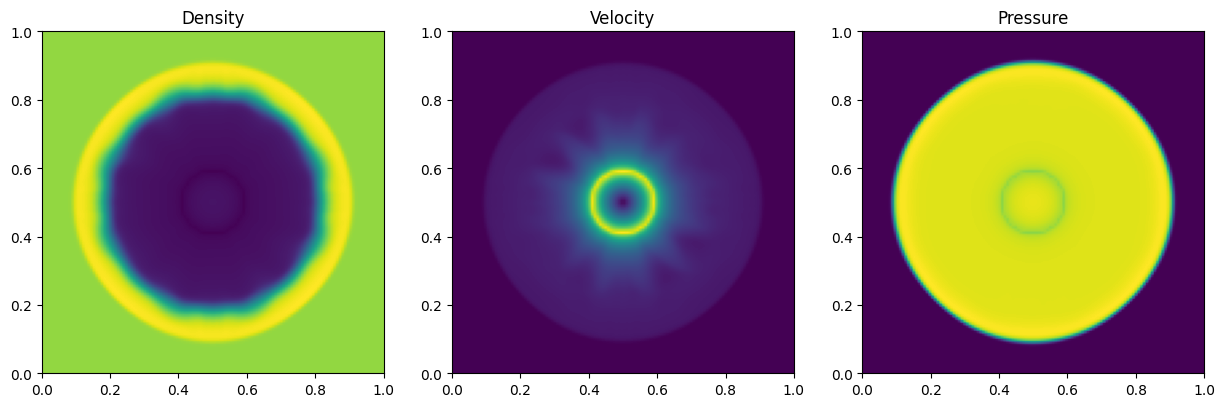

In [17]:
from matplotlib.colors import LogNorm

s = 45

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# equal aspect ratio
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')
ax3.set_aspect('equal', 'box')

z_level = num_cells // 2

xm, ym = jnp.meshgrid(x, y)

# # on the first axis plot the density
# # log scaler
# norm_rho = LogNorm(vmin = jnp.min(final_state[0, :, :, z_level]), vmax = jnp.max(final_state[0, :, :, z_level]), clip = True)
# norm_p = LogNorm(vmin = jnp.min(final_state[4, :, :, z_level]), vmax = jnp.max(final_state[4, :, :, z_level]), clip = True)



# ax1.scatter(xm.flatten() * code_units.code_length, ym.flatten() * code_units.code_length, c = final_state[0, :, :, z_level].flatten(), s = s, marker = "s")
# ax1.set_title("Density")

# # on the second axis plot the absolute velocity
# abs_vel = jnp.sqrt(final_state[1, :, :, z_level]**2 + final_state[2, :, :, z_level]**2 + final_state[3, :, :, z_level]**2)

# vel_norm = LogNorm(vmin = jnp.min(abs_vel), vmax = jnp.max(abs_vel), clip = True)

# ax2.scatter(xm.flatten() * code_units.code_length, ym.flatten() * code_units.code_length, c = abs_vel.flatten(), s = s, marker = "s")
# ax2.set_title("Velocity")

# # on the third axis plot the pressure
# ax3.scatter(xm.flatten() * code_units.code_length, ym.flatten() * code_units.code_length, c = final_state[4, :, :, z_level].flatten(), s = s, marker = "s") # , norm = norm_p)
# ax3.set_title("Pressure")

ax1.imshow(final_state[0, :, :, z_level].T, origin = "lower", extent = [0, 1, 0, 1], norm = LogNorm())
ax1.set_title("Density")

ax2.imshow(jnp.sqrt(final_state[1, :, :, z_level]**2 + final_state[2, :, :, z_level]**2).T, origin = "lower", extent = [0, 1, 0, 1])
ax2.set_title("Velocity")

ax3.imshow(final_state[4, :, :, z_level].T, origin = "lower", extent = [0, 1, 0, 1], norm = LogNorm())
ax3.set_title("Pressure")

In [18]:
print(jnp.min(final_state[1, :, :, z_level]), jnp.max(final_state[1, :, :, z_level]))

-7.665908296309717 7.6599868189842795


In [19]:
# print the minimum 
print(jnp.min(final_state[registered_variables.pressure_index]))

0.016523955885709894


### Weaver comparison

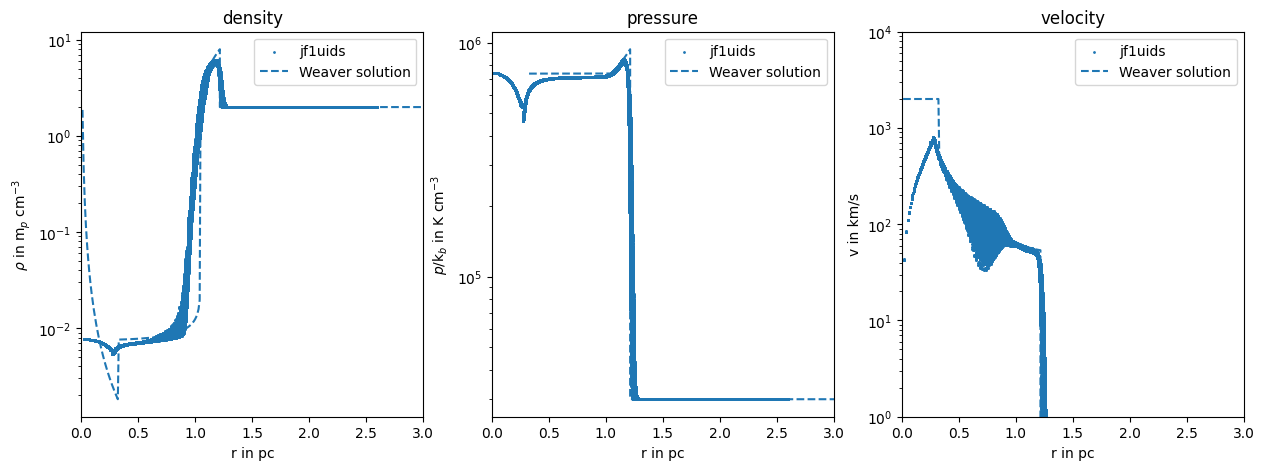

In [20]:
def plot_weaver_comparison(axs, final_state, params, helper_data, code_units, rho_0, p_0):
    rho = final_state[registered_variables.density_index].flatten()
    vel = jnp.sqrt(final_state[registered_variables.velocity_index.x].flatten()**2 + final_state[registered_variables.velocity_index.y].flatten()**2 + final_state[registered_variables.velocity_index.z].flatten()**2)
    p = final_state[registered_variables.pressure_index].flatten()

    rho = rho * code_units.code_density
    vel = vel * code_units.code_velocity
    p = p * code_units.code_pressure

    r = helper_data.r.flatten() * code_units.code_length

    # get weaver solution
    weaver = Weaver(
        params.wind_params.wind_final_velocity * code_units.code_velocity,
        params.wind_params.wind_mass_loss_rate * code_units.code_mass / code_units.code_time,
        rho_0,
        p_0
    )
    
    current_time = params.t_end * code_units.code_time
    
    # density
    r_density_weaver, density_weaver = weaver.get_density_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_density_weaver = r_density_weaver.to(u.parsec)
    density_weaver = (density_weaver / m_p).to(u.cm**-3)

    # velocity
    r_velocity_weaver, velocity_weaver = weaver.get_velocity_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_velocity_weaver = r_velocity_weaver.to(u.parsec)
    velocity_weaver = velocity_weaver.to(u.km / u.s)

    # pressure
    r_pressure_weaver, pressure_weaver = weaver.get_pressure_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_pressure_weaver = r_pressure_weaver.to(u.parsec)
    pressure_weaver = (pressure_weaver / c.k_B).to(u.cm**-3 * u.K)

    axs[0].set_yscale("log")
    axs[0].scatter(r.to(u.parsec), (rho / m_p).to(u.cm**-3), label="jf1uids", s = 1)

    axs[0].plot(r_density_weaver, density_weaver, "--", label="Weaver solution")

    axs[0].set_title("density")
    axs[0].set_ylabel(r"$\rho$ in m$_p$ cm$^{-3}$")
    axs[0].set_xlim(0, 3)

    axs[0].legend(loc="upper right")

    axs[0].set_xlabel("r in pc")

    axs[1].set_yscale("log")
    axs[1].scatter(r.to(u.parsec), (p / c.k_B).to(u.K / u.cm**3), label="jf1uids", s = 1)
    axs[1].plot(r_pressure_weaver, pressure_weaver, "--", label="Weaver solution")

    axs[1].set_title("pressure")
    axs[1].set_ylabel(r"$p$/k$_b$ in K cm$^{-3}$")
    axs[1].set_xlim(0, 3)

    axs[1].legend(loc="upper right")

    axs[1].set_xlabel("r in pc")


    axs[2].set_yscale("log")
    axs[2].scatter(r.to(u.parsec), vel.to(u.km / u.s), label="jf1uids", s = 1)
    axs[2].plot(r_velocity_weaver, velocity_weaver, "--", label="Weaver solution")
    axs[2].set_title("velocity")
    # ylim 1 to 1e4 km/s
    axs[2].set_ylim(1, 1e4)
    axs[2].set_xlim(0, 3)
    axs[2].set_ylabel("v in km/s")
    # xlabel
    # show legend upper left
    axs[2].legend(loc="upper right")

    axs[2].set_xlabel("r in pc")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_weaver_comparison(axs, final_state, params, helper_data, code_units, rho_0, p_0)
# plt.savefig("figures/wind3d_256.png")